In [32]:
%run setup.py

In [6]:
stars = pd.read_csv(rootpath+'numax/sample/samples_rg.csv')
vrard = pd.read_csv('~/Onedrive/Work/database/catalog/vrard+16.csv')
stars = stars.merge(vrard[['KIC', 'DPi1', 'e_DPi1']], on='KIC', how='left')

siml = pd.read_csv('../sample/yixiao_3d/alpha_MLT.csv')
stars = stars.merge(siml[['KIC', 'alpha_MLT_ds', 'alpha_MLT_sbot', 'e_alpha_MLT_ds', 'e_alpha_MLT_sbot', ]], on='KIC', how='left')
# idx = stars['DPi1'].notna() & stars['e_DPi1'].notna()
# stars = stars[idx].reset_index(drop=True)

modes = pd.read_csv(rootpath+'numax/sample/modes_rg.csv')
binary = pd.read_csv(rootpath+'numax/sample/samples_eb.csv')

In [9]:
sufs = ['_m', '_mc']
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'Teff', 'amlt', 'FeH', 'numax_scaling', 'fov_shell', 'fov_core', 'Yinit', 'Zinit']
to_append_cols = [t for suf in sufs for t in ['mass'+suf, 'radius'+suf, 'Dnu'+suf, 'Teff'+suf, 'amlt'+suf, 'feh'+suf, 
                                              'numax'+suf, 'fov_shell'+suf, 'fov_core'+suf, 'Yinit'+suf, 'Zinit'+suf] ]
to_append_e_cols = [t for t in ['e_'+col for col in to_append_cols]]

def multi(inputs):
    istar, star = inputs

    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(2*len(to_append_cols))
    f = h5py.File(filepath, 'r')
    
    # k = (2.2-1.9)/(0.5+0.8)
    # b = 2.2 - k*0.5
    
    # k, b = 0.5646359, 2.1529336
    # e_amlt = 0.05

    # chi2_amlt = (f['amlt'][:] - (k*f['FeH'][:] + b))**2.0 / e_amlt**2.0
    chi2_Teff = (f['Teff'][:]-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_Teff_spec = (f['Teff'][:]-star['Teff_spec'])**2.0 / star['e_Teff_spec']**2.0
    chi2_mh = (f['FeH'][:]-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_mass = (f['star_mass'][:]-star['star_mass'])**2.0 / star['e_star_mass']**2.0
    chi2_radius = (f['radius'][:]-star['radius'])**2.0 / star['e_radius']**2.0
    # chi2_lum = (f['luminosity'][:]-star['luminosity'])**2.0 / star['e_luminosity']**2.0

    chi2_1 = f['chi2_seismic'][:] + chi2_Teff + chi2_mh + chi2_mass + chi2_radius #+ chi2_lum 
    chi2_2 = f['chi2_seismic'][:] + chi2_Teff_spec + chi2_mh + chi2_mass + chi2_radius #+ chi2_lum 

    vars, e_vars = [], []
    for chi2 in [chi2_1, chi2_2]:
        results = quantile(np.array([f[col][:] for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))

        vars.append(list(np.average(np.array([f[col][:] for col in original_cols]).T, weights=np.exp(-chi2/2.), axis=0)))
        e_vars.append(list((results[2,:] - results[0,:])/2.))
    vars = [tt for t in vars for tt in t]
    e_vars = [tt for t in e_vars for tt in t]

    f.close()
    return vars + e_vars

# r = process_map(multi, binary.iterrows(), total=len(binary), max_workers=12)
r = list(tqdm(get_context("fork").Pool(8).imap(multi, binary.loc[:].iterrows()), total=len(binary), position=0))
# len(data)


binary.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)
for suf in sufs:
    binary['fnumax'+suf] = binary['numax']/binary['numax'+suf]
    binary['e_fnumax'+suf] = ((binary['e_numax']/binary['numax'])**2.0 
        + (binary['e_numax'+suf]/binary['numax'+suf])**2.0)**0.5 * binary['fnumax'+suf]


100%|██████████| 10/10 [00:00<00:00, 15.94it/s]


In [10]:
sufs = ['_m', '_mc', '_mf']
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'Teff', 'amlt', 'FeH', 'numax_scaling', 'fov_shell', 'fov_core', 'Yinit', 'Zinit']
to_append_cols = [t for suf in sufs for t in ['mass'+suf, 'radius'+suf, 'Dnu'+suf, 'Teff'+suf, 'amlt'+suf, 
                                               'feh'+suf, 'numax'+suf, 'fov_shell'+suf, 'fov_core'+suf, 
                                               'Yinit'+suf, 'Zinit'+suf] ]
to_append_e_cols = [t for t in ['e_'+col for col in to_append_cols] ]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = h5py.File(filepath, 'r')

    chi2_Teff = (data['Teff'][:]-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_Teff_spec = (data['Teff'][:]-star['Teff_spec'])**2.0 / star['e_Teff_spec']**2.0
    chi2_mh = (data['FeH'][:]-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_lum = (data['luminosity'][:]-star['luminosity'])**2.0 / star['e_luminosity']**2.0
    chi2_numax = (data['numax_scaling'][:]-star['numax'])**2.0 / star['e_numax']**2.0
    # chi2_DPi = (data['delta_Pg'][:]-star['DPi1'])**2.0 / star['e_DPi1']**2.0

    chi2_1 = data['chi2_seismic'][:] + chi2_Teff + chi2_mh + chi2_lum + chi2_numax #+ chi2_DPi
    chi2_2 = data['chi2_seismic'][:] + chi2_Teff_spec + chi2_mh + chi2_lum + chi2_numax #+ chi2_DPi
    chi2_3 = data['chi2_seismic'][:] + chi2_Teff + chi2_mh + chi2_lum #+ chi2_numax #+ chi2_DPi

    vars, e_vars = [], []
    for chi2 in [chi2_1, chi2_2, chi2_3]:
        results = quantile(np.array([data[col][:] for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))
        # vars.append(list(results[1,:]))
        vars.append(list(np.average(np.array([data[col][:] for col in original_cols]).T, weights=np.exp(-chi2/2.), axis=0)))
        e_vars.append(list((results[2,:] - results[0,:])/2.))
    vars = [tt for t in vars for tt in t]
    e_vars = [tt for t in e_vars for tt in t]
    data.close()

    return vars + e_vars

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

100%|██████████| 2786/2786 [01:09<00:00, 40.29it/s]


In [33]:
# stars = stars[stars['e_amlt_m'] > 0.02]

## fit binary amlt vs feh with default Teff setting

100%|██████████| 5000/5000 [00:01<00:00, 3305.90it/s]


(8512, 2)
0 = 0.658 +/- 0.209
1 = 2.137 +/- 0.064


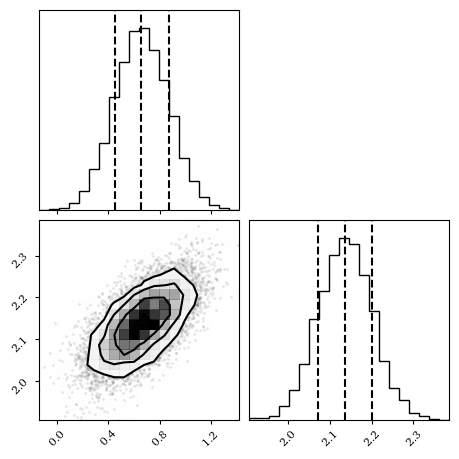

In [12]:
sample = binary[['[M/H]', 'amlt_m', 'e_amlt_m']].dropna()

def log_probability(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

pos = np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(sample['[M/H]'].to_numpy(), sample['amlt_m'].to_numpy(), sample['e_amlt_m'].to_numpy())
)
sampler.run_mcmc(pos, 5000, progress=True);


# fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

flat_samples1 = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples1.shape)

fig = corner.corner(flat_samples1, quantiles=[0.16, 0.50, 0.84]);

for i in range(ndim):
    mcmc = np.percentile(flat_samples1[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "= {0:.3f} +/- {1:.3f}"
    txt = txt.format(mcmc[1], (q[0]+q[1])/2. )
    print(i, txt)

    

In [9]:
# m, b = [4,4]
# x, y, yerr = sample['[M/H]'].to_numpy(), sample['amlt_m'].to_numpy(), sample['e_amlt_m'].to_numpy()
# model = m * x + b
# sigma2 = yerr**2
# -0.5 * np.sum((y - model) ** 2 / sigma2)

## fit single stars amlt vs feh with default Teff setting

100%|██████████| 5000/5000 [00:01<00:00, 2607.72it/s]


(8512, 2)
0 = 0.195 +/- 0.000
1 = 1.904 +/- 0.000


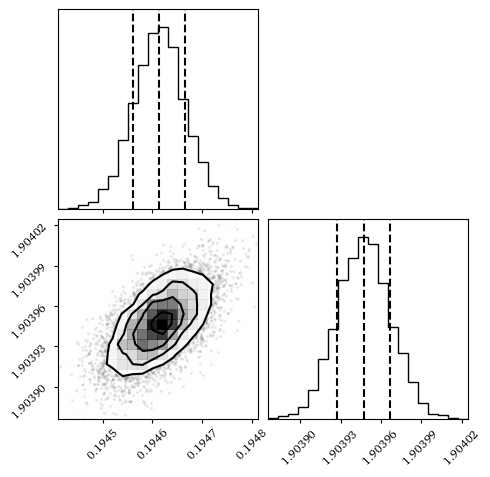

In [13]:
sample = stars[['[M/H]', 'amlt_m', 'e_amlt_m']].dropna().query('e_amlt_m != 0.')

def log_probability(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

pos = np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(sample['[M/H]'].to_numpy(), sample['amlt_m'].to_numpy(), sample['e_amlt_m'].to_numpy())
)
sampler.run_mcmc(pos, 5000, progress=True);

flat_samples2 = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples2.shape)

fig = corner.corner(flat_samples2, quantiles=[0.16, 0.50, 0.84]);
for i in range(ndim):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "= {0:.3f} +/- {1:.3f}"
    txt = txt.format(mcmc[1], (q[0]+q[1])/2. )
    print(i, txt)

## fit binary amlt vs feh with alternative Teff setting

100%|██████████| 5000/5000 [00:01<00:00, 3276.22it/s]


(8512, 2)
0 = 0.599 +/- 0.138
1 = 2.134 +/- 0.063


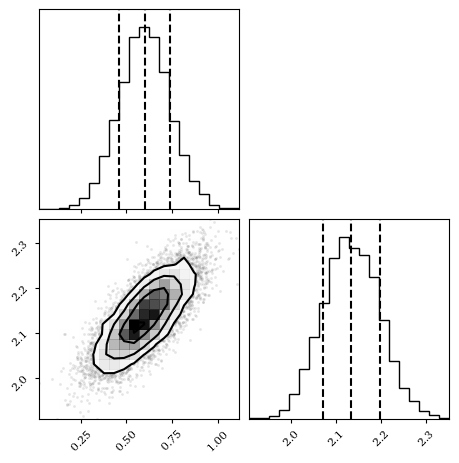

In [14]:
sample = binary[['[M/H]', 'amlt_mc', 'e_amlt_mc']].dropna()

def log_probability(theta, x, y, yerr):
    # lp = log_prior(theta)
    # if not np.isfinite(lp):
        # return -np.inf
    # return lp + log_likelihood(theta, x, y, yerr)
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

pos = np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(sample['[M/H]'].to_numpy(), sample['amlt_mc'].to_numpy(), sample['e_amlt_mc'].to_numpy())
)
sampler.run_mcmc(pos, 5000, progress=True);


# fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

flat_samples3 = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples3.shape)

fig = corner.corner(flat_samples3, quantiles=[0.16, 0.50, 0.84]);
for i in range(ndim):
    mcmc = np.percentile(flat_samples3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "= {0:.3f} +/- {1:.3f}"
    txt = txt.format(mcmc[1], (q[0]+q[1])/2. )
    print(i, txt)

# Figure

In [33]:
stars['alpha_MLT_sbot']

0       1.907831
1       1.895386
2       1.898882
3       1.906819
4       1.936608
          ...   
2781    1.864724
2782    1.897134
2783    1.882585
2784    1.875791
2785    1.899481
Name: alpha_MLT_sbot, Length: 2786, dtype: float64

0

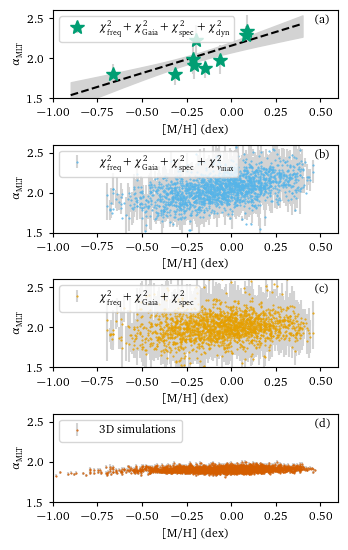

In [24]:
fig, axes = plt.subplots(figsize=figsize(ratio=1.2/3*4, column='one'), nrows=4, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

axes[0].errorbar(binary['[M/H]'], binary['amlt_m'], yerr=binary['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

axes[1].errorbar(stars['[M/H]'], stars['amlt_m'], yerr=stars['e_amlt_m'], 
            linestyle='none', marker='.', ms=1, ecolor='lightgray', color=colors[1], zorder=-10, label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\nu_{\rm max}}$')

axes[2].errorbar(stars['[M/H]'], stars['amlt_mf'], yerr=stars['e_amlt_mf'], 
            linestyle='none', marker='.', ms=1, ecolor='lightgray', color=colors[0], zorder=-20, label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec}$')

axes[3].errorbar(stars['[M/H]'], stars['alpha_MLT_sbot'], yerr=stars['e_alpha_MLT_sbot'],
            linestyle='none', marker='.', ms=1, ecolor='lightgray', color=colors[3], zorder=-20, label=r'3D simulations')

# axes[3].errorbar(stars['[M/H]'], stars['alpha_MLT_ds'], yerr=stars['e_alpha_MLT_ds'],
#             linestyle='none', marker='.', ms=1, ecolor='lightgray', color=colors[4], zorder=-20, label=r'3D simulations')

idx = binary['amlt_m'].notna()
# k, b = np.polyfit(binary.loc[idx,'[M/H]'].to_numpy(), binary.loc[idx,'amlt_m'].to_numpy(), 1, w=binary.loc[idx,'e_amlt_m'].to_numpy())
# k = (2.3-1.8)/(0.2-(-0.7)); b = 2.3 - k*0.2
k = 0.684; b = 2.155
xs = np.linspace(-0.9, 0.4); ys = xs*k + b
axes[0].plot(xs, ys, 'k--')
ycs1, ycs2 = [np.zeros(len(xs)) for i in range(2)]
for i in range(len(xs)):
    ycs1[i] = np.percentile( flat_samples1[:,0]*xs[i] + flat_samples1[:,1], 16 )
    ycs2[i] = np.percentile( flat_samples1[:,0]*xs[i] + flat_samples1[:,1], 84 )
axes[0].fill_between(xs, ycs1, ycs2, color='lightgray')
# print(k, b)

ss = ['(a)', '(b)', '(c)', '(d)']
for iax in range(4):
    axes[iax].set_ylabel(r'$\alpha_{\rm MLT}$')
    axes[iax].set_xlabel('[M/H] (dex)')
    axes[iax].set_xlim(-1., 0.6)
    axes[iax].set_ylim(1.5, 2.6)
    axes[iax].legend(loc='upper left')
    axes[iax].text(0.92, 0.85, ss[iax], transform=axes[iax].transAxes)


filename = 'Fig.5_amlt_feh.pdf'
plt.savefig(filename, dpi=300)
os.system(to_overleaf(filename, 'figures'))

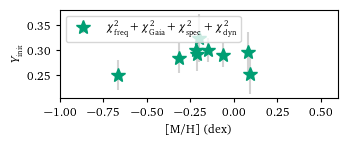

In [36]:
fig, axes = plt.subplots(figsize=figsize(ratio=0.4, column='one'), nrows=1, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

axes[0].errorbar(binary['[M/H]'], binary['Yinit_m'], yerr=binary['e_Yinit_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

for iax in range(1):
    axes[iax].set_ylabel(r'$Y_{\rm init}$')
    axes[iax].set_xlabel('[M/H] (dex)')
    axes[iax].set_xlim(-1., 0.6)
    # axes[iax].set_ylim(1.5, 2.6)
    axes[iax].legend(loc='upper left')

In [24]:
binary[['amlt_m', '[M/H]', 'Yinit_m', 'mass_m', 'radius_m', 'Teff_m']].corr()['amlt_m']

amlt_m      1.000000
[M/H]       0.755841
Yinit_m    -0.022812
mass_m      0.740870
radius_m   -0.298978
Teff_m      0.702408
Name: amlt_m, dtype: float64

In [25]:
stars[['amlt_m', '[M/H]', 'Yinit_m', 'mass_m', 'radius_m', 'Teff_m']].corr()['amlt_m']

amlt_m      1.000000
[M/H]       0.465297
Yinit_m    -0.493087
mass_m      0.108354
radius_m   -0.001192
Teff_m      0.027153
Name: amlt_m, dtype: float64

Text(0.5, 0, 'Teff (K)')

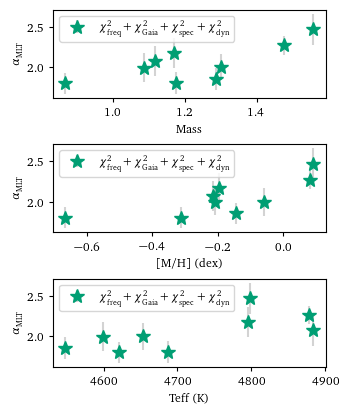

In [21]:
fig, axes = plt.subplots(figsize=figsize(ratio=0.4*3, column='one'), nrows=3, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

axes[0].errorbar(binary['mass_m'], binary['amlt_m'], yerr=binary['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

axes[1].errorbar(binary['[M/H]'], binary['amlt_m'], yerr=binary['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')


axes[2].errorbar(binary['Teff_m'], binary['amlt_m'], yerr=binary['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

for iax in range(3):
    axes[iax].set_ylabel(r'$\alpha_{\rm MLT}$')
    # axes[iax].set_xlim(-1., 0.6)
    # axes[iax].set_ylim(1.5, 2.6)
    axes[iax].legend(loc='upper left')

axes[0].set_xlabel(r'Mass')
axes[1].set_xlabel(r'[M/H] (dex)')
axes[2].set_xlabel('Teff (K)')

Text(0.5, 0, 'Yinit')

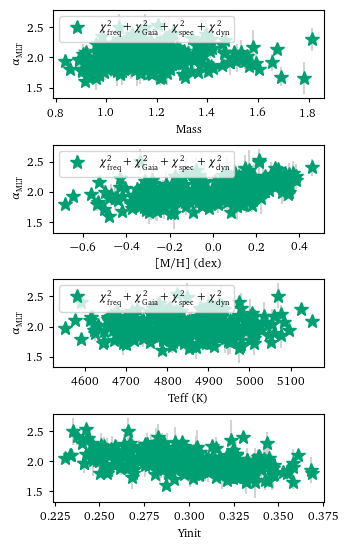

In [27]:
fig, axes = plt.subplots(figsize=figsize(ratio=0.4*4, column='one'), nrows=4, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

axes[0].errorbar(stars['mass_m'], stars['amlt_m'], yerr=stars['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

axes[1].errorbar(stars['[M/H]'], stars['amlt_m'], yerr=stars['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

axes[2].errorbar(stars['Teff_m'], stars['amlt_m'], yerr=stars['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

axes[3].errorbar(stars['Yinit_m'], stars['amlt_m'], yerr=stars['e_amlt_m'], 
            linestyle='none', marker='*', ms=10, ecolor='lightgray', color=colors[2], label=r'$\chi^2_{\rm freq} + \chi^2_{\rm Gaia} + \chi^2_{\rm spec} + \chi^2_{\rm dyn}$')

for iax in range(3):
    axes[iax].set_ylabel(r'$\alpha_{\rm MLT}$')
    # axes[iax].set_xlim(-1., 0.6)
    # axes[iax].set_ylim(1.5, 2.6)
    axes[iax].legend(loc='upper left')

axes[0].set_xlabel(r'Mass')
axes[1].set_xlabel(r'[M/H] (dex)')
axes[2].set_xlabel('Teff (K)')
axes[3].set_xlabel('Yinit')